In [1]:
import altair as alt
import pandas as pd
import numpy as np

* 좌측 네 번째 메뉴 (폴더모양 아이콘) 클릭 후 세션 저장소에 제공된 파일을 업로드 혹은,
  * ``` df = pd.read_csv("./filename.csv")```
* 드라이브 마운트 하여 드라이브에 저장된 파일 사용
  * ``` df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/filename.csv")```


# Time-series data visualization (Google Earth Data)

## Introduction

### 사용 데이터셋

기후

- Drought severity ([PDSI](https://developers.google.com/earth-engine/datasets/catalog/GRIDMET_DROUGHT))
- Historical climate ([PRISM](https://developers.google.com/earth-engine/datasets/catalog/OREGONSTATE_PRISM_AN81m))
- Projected climate ([NEX-DCP30](https://developers.google.com/earth-engine/datasets/catalog/NASA_NEX-DCP30))

대표 식생 (Vegetation proxies)

- NDVI ([MODIS](https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD13A2))
- NBR ([Landsat](https://developers.google.com/earth-engine/datasets/catalog/landsat/))

### 지역

California의 Sierra Nevada ecoregion.
- 서쪽의 저지대 : 폰다로사네, 더글러스 전나무 (ponderosa pine and Douglas-fir)
- 동쪽 : 소나무, 시에라 향나무 (pines and Sierra juniper)
- 고지대 : 전나무, 침엽수 (fir and other conifers)

### 일반적인 분석 흐름

시각화를 위해 데이터셋을 준비하는 과정은 대부분 아래의 기본적인 과정을 거칩니다. 

1. 데이터셋 필터링 (서버-사이드 Earth Engine)
2. 통계 등을 사용해 데이터 정제 (서버-사이드 Earth Engine)
3. 정제된 데이터를 table 형식으로 변형 (server-side Earth Engine)
4. table을 pandas DataFrmae으로 변환(서버 > client Python kernel)
5. DataFrame 변형Alter the DataFrame (pandas)
6. DataFrame 시각화 (Altair)

## Drought severity (PDSI)

가뭄의 정도를 알려주는 PDSI 데이터셋을 활용하여 heat map과 bar chart로 시각화를 해봅시다. 

In [2]:
# pandas를 활용하여 csv 파일을 읽어옵니다. 
pdsi_df = pd.read_csv('./pdsi.csv')
pdsi_df.head()

,millis,pdsi,system:index
0,1023170400000,-1.970011,20020604
1,1023602400000,-1.962887,20020609
2,1024034400000,-1.954269,20020614
3,1024466400000,-1.979315,20020619
4,1024898400000,-2.026320,20020624


### add column

* millis : Unix timestamp (milliseconds)
  * timestamp에서 실제 year, month, day, DOY (day of year)를 추출해봅시다. 
  * pandas library에서 제공하는 변환함수를 사용할 수 있습니다. 

In [3]:
# Function to add date variables to DataFrame.
def add_date_info(df):
  df['Timestamp'] = pd.to_datetime(df['millis'], unit='ms')
  df['Year'] = pd.DatetimeIndex(df['Timestamp']).year
  df['Month'] = pd.DatetimeIndex(df['Timestamp']).month
  df['Day'] = pd.DatetimeIndex(df['Timestamp']).day
  df['DOY'] = pd.DatetimeIndex(df['Timestamp']).dayofyear
  return df

In [4]:
pdsi_df = add_date_info(pdsi_df)
pdsi_df.head(5)

,millis,pdsi,system:index,Timestamp,Year,Month,Day,DOY
0,1023170400000,-1.970011,20020604,2002-06-04 06:00:00,2002,6,4,155
1,1023602400000,-1.962887,20020609,2002-06-09 06:00:00,2002,6,9,160
2,1024034400000,-1.954269,20020614,2002-06-14 06:00:00,2002,6,14,165
3,1024466400000,-1.979315,20020619,2002-06-19 06:00:00,2002,6,19,170
4,1024898400000,-2.026320,20020624,2002-06-24 06:00:00,2002,6,24,175


### rename, drop columns

* 불필요한 column을 제거하고 column의 이름을 바꿉니다. 

In [5]:
pdsi_df = pdsi_df.rename(columns={
    'pdsi': 'PDSI'
})

# TODO : drop 'millis', 'system:index' column

pdsi_df.pop("millis")
pdsi_df.pop('system:index')

pdsi_df.head(5)

,PDSI,Timestamp,Year,Month,Day,DOY
0,-1.970011,2002-06-04 06:00:00,2002,6,4,155
1,-1.962887,2002-06-09 06:00:00,2002,6,9,160
2,-1.954269,2002-06-14 06:00:00,2002,6,14,165
3,-1.979315,2002-06-19 06:00:00,2002,6,19,170
4,-2.026320,2002-06-24 06:00:00,2002,6,24,175


In [6]:
# 각 column의 타입을 확인해봅시다. 
pdsi_df.dtypes

PDSI                float64
Timestamp    datetime64[ns]
Year                  int64
Month                 int64
Day                   int64
DOY                   int64
dtype: object

### Calendar heatmap

* PDSI 데이터로 heatmap 을 그려봅시다. 
  * x축 : year
  * y축 : month
  * color : 해당 년 / 월의 PDSI value **평균값**
    * 평균으로 aggregation 해야합니다. 
    * alt.Color()에 scale 인자로 아래 값을 추가해줍니다. 
alt.Scale(scheme='redblue', domain=(-5, 5))
    `  `

In [15]:
alt.Chart(pdsi_df).mark_rect().encode(
    x="Year:O",
    y="Month:O",
    color = alt.Color("mean(PDSI)", scale=alt.Scale(scheme='redblue', domain=(-5, 5)))
).properties(width=600, height=300)

alt.Chart(...)

* heatmap을 그렸으면, tooltip을 추가해봅시다. 아래의 값이 모두 표현되어야 합니다.
  * X, Y, color (Year, Month, PDSI value의 평균값)

In [17]:
alt.Chart(pdsi_df).mark_rect().encode(
    x="Year:O",
    y="Month:O",
    color = alt.Color("mean(PDSI)", scale=alt.Scale(scheme='redblue', domain=(-5, 5))),
    tooltip=['Year:O', 'Month:O', 'mean(PDSI)']
).properties(width=600, height=300).interactive()

alt.Chart(...)

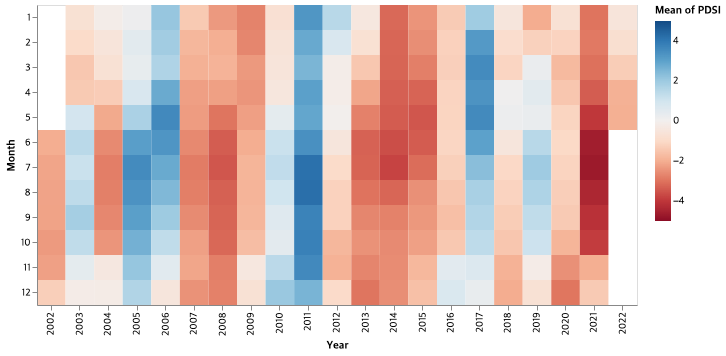

### Bar chart

* PDSI 시계열 데이터를 bar chart를 통해 분석해봅시다. 
  * x축 : Timestamp
  * y축 : PDSI
  * Color : PDSI 
    * `scale = alt.Scale(scheme='redblue', domain=(-5, 5))`
  * Tooltip : x축, y축 (Timestamp, PDSI)
  
* 여기서는 각 timestamp마다 PDSI value가 대응되므로 위의 예시처럼  aggregation을 할 필요가 없습니다.

In [23]:
alt.Chart(pdsi_df).mark_bar(size=1).encode(
    x="Timestamp",
    y="PDSI:Q",
    color=alt.Color("PDSI", scale = alt.Scale(scheme='redblue', domain=(-5, 5))),
    tooltip = [alt.Tooltip()]
    
).properties(width=600, height=300)

alt.Chart(...)

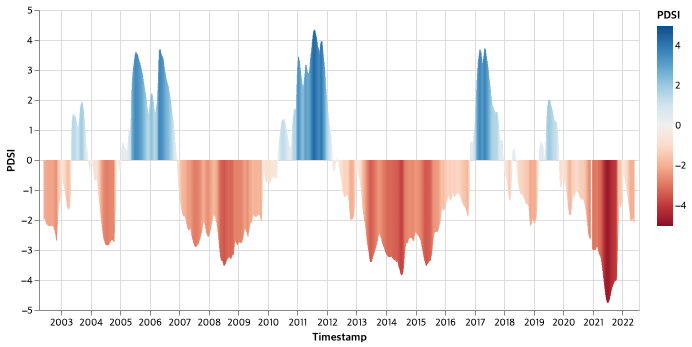

## Vegetation productivity (NDVI)

* NDVI 는 광합성 능력을 측정하는 수치입니다. NDVI 수치를 활용해서 vegetation response를 관찰할 수 있습니다.

In [21]:
ndvi_df = pd.read_csv('./ndvi.csv')
ndvi_df.head()

,NDVI,millis,system:index,Timestamp,Year,Month,Day,DOY
0,0.497605,1023667200000,2002_06_10,2002-06-10,2002,6,10,161
1,0.507304,1025049600000,2002_06_26,2002-06-26,2002,6,26,177
2,0.513145,1026432000000,2002_07_12,2002-07-12,2002,7,12,193
3,0.509395,1027814400000,2002_07_28,2002-07-28,2002,7,28,209
4,0.498719,1029196800000,2002_08_13,2002-08-13,2002,8,13,225


### DOY line chart

* DOY (day of year) 칼럼을 활용해서 line chart를 그려봅시다. 각 선은 1년을 의미하도록 색상으로 구분되어져야 합니다. 
  * x축 : Day of year
    * ` scale=alt.Scale(domain=[0, 353], clamp=True) `
  * y축 : NDVI value
    * ` scale=alt.Scale(domain=[0.1, 0.6]) `
  * Color : Year
    * ` scale=alt.Scale(scheme='magma') `
  * Tooltip : x축, y축, color

In [22]:
alt.Chart(ndvi_df).mark_line().encode(
    x=alt.X("DOY", scale=alt.Scale(domain=[0, 353], clamp=True)),
    y=alt.Y("NDVI", scale=alt.Scale(domain=[0.1, 0.6])),
    color = alt.Color("Year",scale=alt.Scale(scheme='magma'))

).properties(width=600, height=350)

alt.Chart(...)

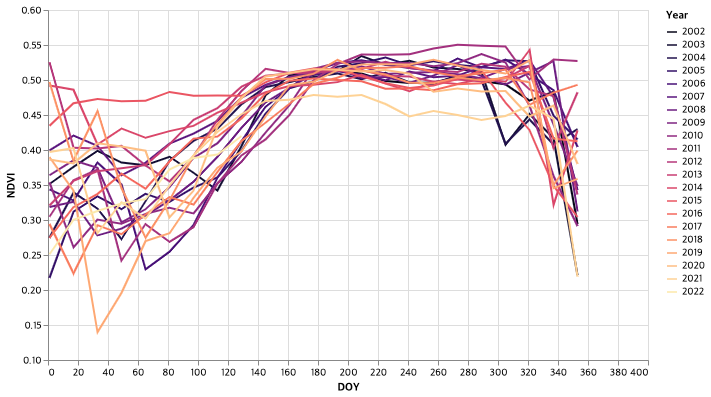

* selection을 이용하여 각 line에 mouse over하였을 때, 선이 굵어지도록 바꿔봅시다.
  * 정확히 선분위가 아닌, 선분 인근에서도 선택이 가능하도록 `nearest` Flag를 `False`로 설정합니다.

* zooming과 panning이 가능한 interactive chart로 만들어 봅시다.

In [ ]:
# 위의 차트에서  mark를 제거합니다. encoding은 위와 동일하게 사용합니다.
base = alt.Chart(ndvi_df).encode(
    )


# single selection을 사용합니다
highlight = alt.selection_single(on='', fields=['Year'], nearest=, )

# line chart의 size에 hightlight condition을 binding 합니다.
# 선택이 된 경우 alt.value(3), 선택이 되지 않은 경우 alt.value(1)이 되도록 합니다.
lines = base.mark_line().encode(
    size=alt.condition()
)

# points에 selection을 추가합니다.
points = base.mark_circle().encode(
    opacity=alt.value(0)
).add_selection(highlight)


(points + lines).properties(width=600, height=350)

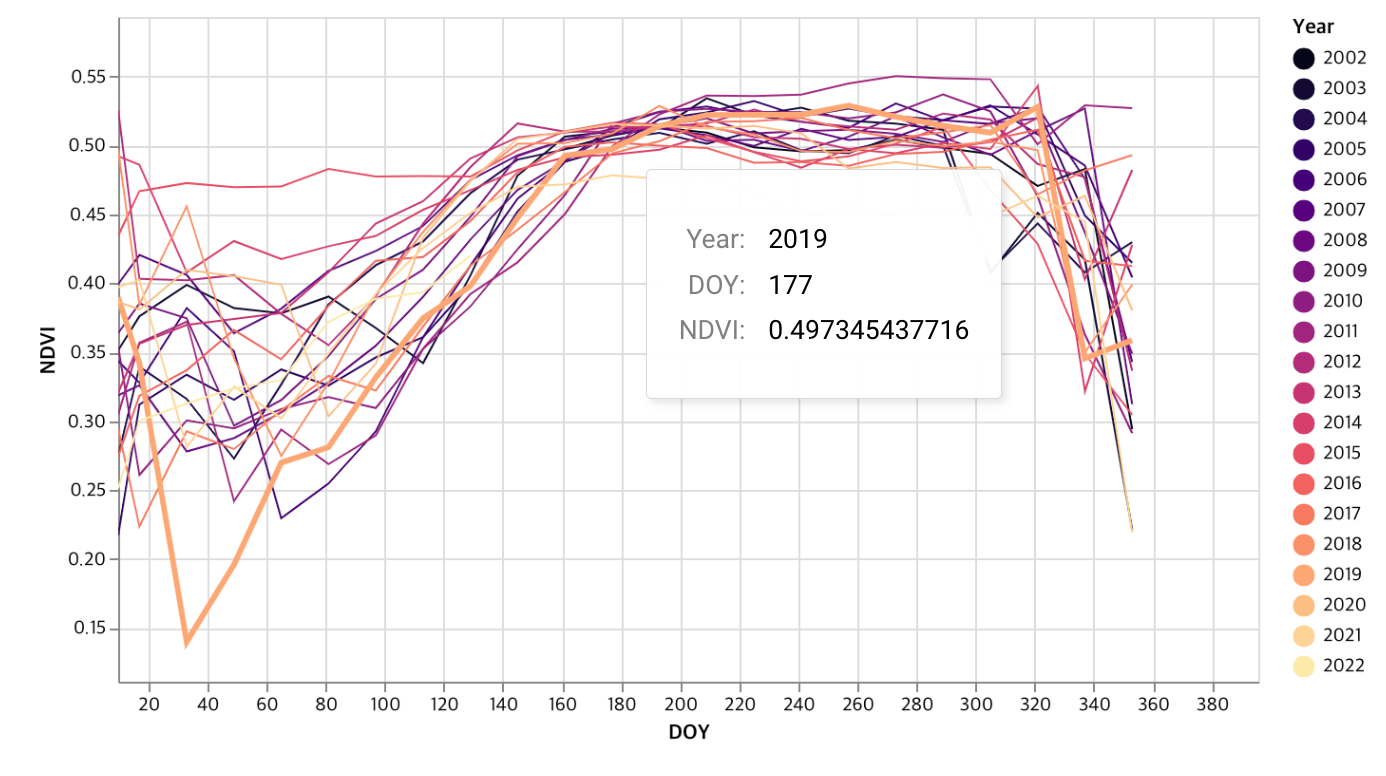

위의 데이터를 다른 방식으로도 시각화가 가능합니다.
  * x : DOY
  * line : median(NDVI)
  * errorband : `iqr` (Q1 to Q3)

In [ ]:
line = alt.Chart(ndvi_df).mark_line().encode(
    x=alt.X('DOY:Q', scale=alt.Scale(domain=(150, 340))),
    y=alt.Y('median(NDVI):Q', scale=alt.Scale(domain=(0.47, 0.53))))

band = alt.Chart(ndvi_df).mark_errorband(extent='iqr').encode(
    x=alt.X('DOY:Q', scale=alt.Scale(domain=(150, 340))),
    y='NDVI:Q')

(line + band).properties(width=600, height=300).interactive()

alt.LayerChart(...)

## Dought and productivity relationship

* 두 데이터셋의 관련성을 시각화 해봅시다. 
  * PDSI (drought) 를 x축에, NDVI (vegetation productivity) 를 y축으로 사용한 산점도를 그려볼 수 있습니ㅏ.
  * 이를 위해 두 dataframe을 하나로 합쳐야 합니다.

### Prepare DataFrames
 * 각 dataframe을 공통의 시간단위로 변경합니다. 

 * NDVI, PDSI값을 아래와 같은 기준으로 사용합니다.
    * NDVI : DOY 224-272 사이의 데이터 중 최솟값
    * PDSI : DOY 1 - 272 사이의 데이터의 평균값

  * 목적 : 연초부터 272 (3분기)까지의 PDSI값과 여름의 NDVI값의 관련성 분석

In [ ]:
ndvi_doy_range = [224, 272]

# 1.데이터셋을 224, 272일 사이만 filtering 합니다.  
ndvi_df_sub = 

# 2. groupby를 사용해 year로 묶고, 최소값으로 aggregation
ndvi_df_sub = ndvi_df_sub.groupby('Year').agg('min')

In [ ]:
pdsi_doy_range = [1, 272]

# 1. 데이터셋을 1, 272일 사이만 filtering 합니다.  
pdsi_df_sub = 

# 2. groupby를 사용해 year로 묶고, 평균값으로 aggregation
pdsi_df_sub = 

In [ ]:
ndvi_pdsi_df = pd.merge(
    ndvi_df_sub, pdsi_df_sub, how='left', on='Year').reset_index()


# TODO : year, ndvi, pdsi column만 남깁니다.
ndvi_pdsi_df = 

ndvi_pdsi_df.head(5)

,Year,NDVI,PDSI
0,2002,0.495745,-2.128436
1,2003,0.517990,0.242176
2,2004,0.494287,-1.748000
3,2005,0.521052,1.839990
4,2006,0.512876,2.509618


In [ ]:
ndvi_pdsi_df['Fit'] = np.poly1d(
    np.polyfit(ndvi_pdsi_df['PDSI'], ndvi_pdsi_df['NDVI'], 1))(
        ndvi_pdsi_df['PDSI'])

ndvi_pdsi_df.head(5)

,Year,NDVI,PDSI,Fit
0,2002,0.495745,-2.128436,0.491771
1,2003,0.517990,0.242176,0.508815
2,2004,0.494287,-1.748000,0.494506
3,2005,0.521052,1.839990,0.520303
4,2006,0.512876,2.509618,0.525117


### Scatter plot
* 아래의 두 차트를 각각 만들어서 합쳐봅시다. 
  * PDSI, NDVI의 관련성을 나타내는 scatterplot
    * x : PDSI
      * ` scale=alt.Scale(domain=(-5, 5)) `
    * y : NDVI
      * ` scale=alt.Scale(domain=(0.4, 0.6)) `
    * color : Year
      * ` scale=alt.Scale(scheme='magma') `
    * Tooltip : x, y, colo r(PDSI, NDVI, Year)



In [ ]:
points = alt.Chart(ndvi_pdsi_df).mark_circle(size=60)

* Line chart
  * 계산된 best fit line을 보여줍니다. 
    * x : PDSI
      * ` scale=alt.Scale(domain=(-5, 5)) `
    * y : NDVI
    * color : ` alt.value('#808080') `
    * Tooltip : x, y (PDSI, NDVI)

In [ ]:
fit = alt.Chart(ndvi_pdsi_df).mark_line()


(points + fit).properties(width=600, height=300).interactive()

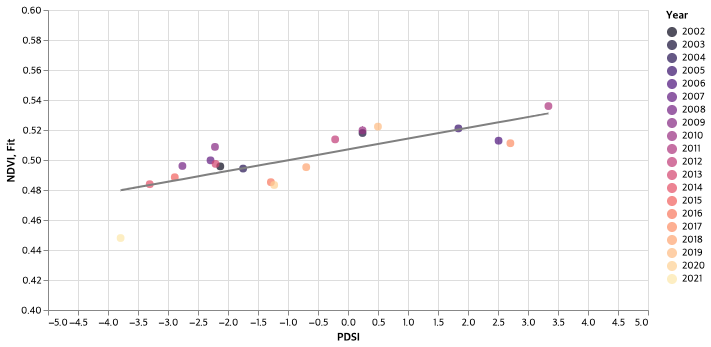

## Landsat surface reflectance collection (NBR)

* NBR : 반사율 데이터를 측정
* 산림파괴 정도를 추정 가능

### Find a point of interest

* 아래의 지도에서 예제를 위해 사용할 위치를 확인할 수 있습니다. 

In [ ]:
nbr_df = pd.read_csv('./nbr.csv')
nbr_df.head()

,NBR,millis,system:index,Timestamp,Year,Month,Day,DOY
0,0.736023,1375381797010,1_1_LC08_041035_20130817,2013-08-01 18:29:57.010,2013,8,1,213
1,0.710447,1406917680770,1_1_LC08_041035_20140820,2014-08-01 18:28:00.770,2014,8,1,213
2,0.634862,1438453662550,1_1_LC08_041035_20150823,2015-08-01 18:27:42.550,2015,8,1,213
3,0.439845,1470076084946,1_1_LC08_041035_20160825,2016-08-01 18:28:04.946,2016,8,1,214
4,0.365358,1501612078280,1_1_LC08_041035_20170812,2017-08-01 18:27:58.280,2017,8,1,213


### Line chart

- NBR
* NBR 데이터를 활용해서 line chart를 그려봅시다. 각 선은 1년을 의미하도록 색상으로 구분되어져야 합니다. 
  * x축 : Timestamp
     ` title='Date' `
  * y축 : NBR value
  * Tooltip : x축, y축

In [ ]:
alt.Chart(nbr_df).mark_line().properties(width=600, height=300).interactive()

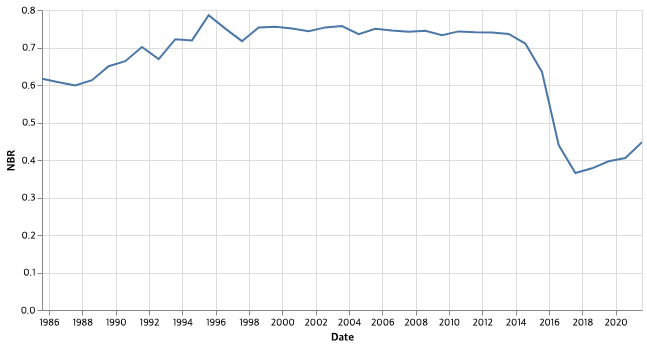

## Past and future climate
* PDSI, NDVI데이터를 활용하여 Sierra Nevada ecoregion에서 식물의 생장과 가뭄의 관계를 확인하였습니다. 
* 이번에는, 가뭄에 따른 기후의 변화와, 식물생장에 미치는 영향을 데이터를 통해 분석해보고자 합니다. 
* 과거(PRISM)와 예상되는 (NEX-DCP30) 기후 데이터를 사용합니다. 


### Prepare datasets
#### 미래 기후

* NEX-DCP30: 온실가스 농도 경로 (RCP)의 여러 시나리오를 활용하여, 2100년의 예상되는 33개의 기후 모델이 포함되어 있다. 이 중 RCP 8.5 (최악의 경우)에 대한 데이터 (온도, 강수량)를 사용합니다. 

#### 과거 기후

* 과거 강수량, 온도

In [ ]:
dcp_df = pd.read_csv('./dcp.csv')
dcp_df.head()

,Temp-mean,millis,system:index,Timestamp,Year,Month,Day,DOY,Precip-mm,Model
0,2.131555,1546300800000,rcp85_201901,2019-01-01,2019,1,1,1,137.895591,NEX-DCP30
1,2.951105,1548979200000,rcp85_201902,2019-02-01,2019,2,1,32,136.259718,NEX-DCP30
2,4.230051,1551398400000,rcp85_201903,2019-03-01,2019,3,1,60,97.100616,NEX-DCP30
3,7.771967,1554076800000,rcp85_201904,2019-04-01,2019,4,1,91,62.798731,NEX-DCP30
4,11.661691,1556668800000,rcp85_201905,2019-05-01,2019,5,1,121,10.855026,NEX-DCP30


In [ ]:
prism_df = pd.read_csv('./prism.csv')
prism_df.head()

,millis,Precip-mm,system:index,Temp-mean,Timestamp,Year,Month,Day,DOY,Model
0,283996800000,116.820000,197901,-2.430000,1979-01-01,1979,1,1,1,PRISM
1,286675200000,231.960007,197902,-1.215000,1979-02-01,1979,2,1,32,PRISM
2,289094400000,197.570007,197903,1.610000,1979-03-01,1979,3,1,60,PRISM
3,291772800000,22.930000,197904,4.810000,1979-04-01,1979,4,1,91,PRISM
4,294364800000,44.139999,197905,10.320001,1979-05-01,1979,5,1,121,PRISM


### Combine DataFrames

* 두개의 데이터셋이 동일한 column을 가지고, Model column의 값으로 구분됩니다. 
  * pandas `concat` 함수를 사용해 두 데이터 프레임을 합쳐봅시다. 

In [ ]:
climate_df = pd.concat([prism_df, dcp_df], sort=True)
climate_df

,DOY,Day,Model,Month,Precip-mm,Temp-mean,Timestamp,Year,millis,system:index
0,1,1,PRISM,1,116.820000,-2.430000,1979-01-01,1979,283996800000,197901
1,32,1,PRISM,2,231.960007,-1.215000,1979-02-01,1979,286675200000,197902
2,60,1,PRISM,3,197.570007,1.610000,1979-03-01,1979,289094400000,197903
3,91,1,PRISM,4,22.930000,4.810000,1979-04-01,1979,291772800000,197904
4,121,1,PRISM,5,44.139999,10.320001,1979-05-01,1979,294364800000,197905
...,...,...,...,...,...,...,...,...,...,...
607,213,1,NEX-DCP30,8,2.901624,23.449380,2069-08-01,2069,3142540800000,rcp85_206908
608,244,1,NEX-DCP30,9,4.777050,20.550165,2069-09-01,2069,3145219200000,rcp85_206909
609,274,1,NEX-DCP30,10,3.275994,15.496957,2069-10-01,2069,3147811200000,rcp85_206910
610,305,1,NEX-DCP30,11,46.470346,9.660562,2069-11-01,2069,3150489600000,rcp85_206911


### 시각화 

* 과거와 미래의 강수량, 온도를 동시에 비교해 봅시다. 
* NDVI 데이터를 median, iqr의 시각화와 동일하게 만들어 봅시다. 
```
line = alt.Chart(ndvi_df).mark_line().encode(
    x=alt.X('DOY:Q', scale=alt.Scale(domain=(150, 340))),
    y=alt.Y('median(NDVI):Q', scale=alt.Scale(domain=(0.47, 0.53))))
```
```
band = alt.Chart(ndvi_df).mark_errorband(extent='iqr').encode(
    x=alt.X('DOY:Q', scale=alt.Scale(domain=(150, 340))),
    y='NDVI:Q')
```
```
(line + band).properties(width=600, height=300).interactive()
```
  * 단, 과거와 미래의 데이터가 구분되게 Model field를 사용해 봅시다. 

#### Precipitation

* 사용 column : year, precip-mm, model 

In [ ]:
line = alt.Chart(climate_df)

band = alt.Chart(climate_df)

(band + line).properties(width=600, height=300)

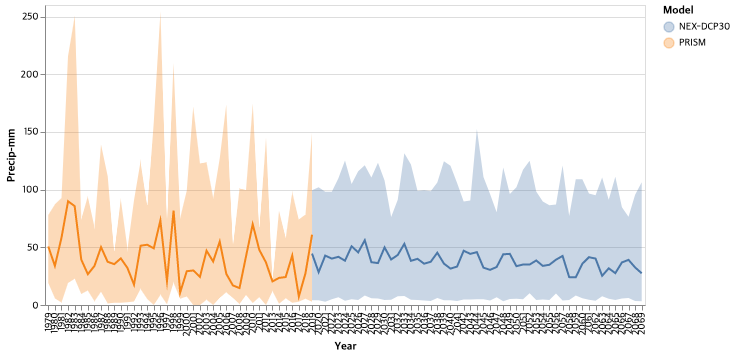

#### Temperature

* 사용 column : year, Temp-mean, model 

In [ ]:
line = alt.Chart(climate_df)

band = alt.Chart(climate_df)

(band + line).properties(width=600, height=300)

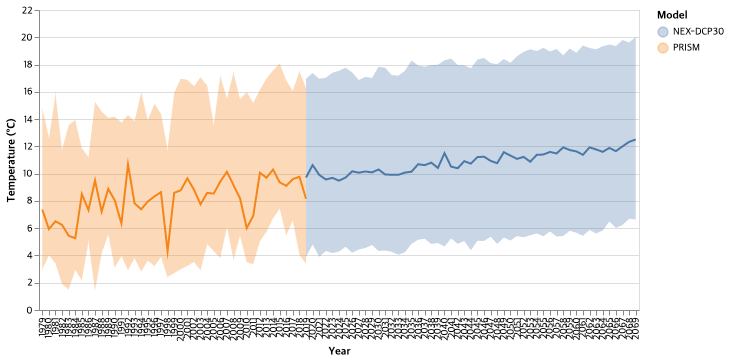